In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import massspecgym.utils as utils
from pandarallel import pandarallel
from matchms.importing import load_from_mgf
from tqdm import tqdm
tqdm.pandas()
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula, CalcExactMolWt
from pandarallel import pandarallel
utils.init_plotting(figsize=(4, 4))
%reload_ext autoreload
%autoreload 2

from rdkit import RDLogger

# Disable RDKit logging
RDLogger.DisableLog('rdApp.*')

In [2]:
df_1M = pd.read_csv('/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGym_retrieval_molecules_1M.tsv', sep='\t')
df_1M.shape, df_1M.columns

((1032456, 5),
 Index(['smiles', 'inchi_key_2D', 'inchi', 'formula', 'weight'], dtype='object'))

In [3]:
df_4M = pd.read_csv('/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGym_retrieval_molecules_4M.tsv', sep='\t', na_values=['\\N', ''])
df_4M.shape, df_4M.columns

((4175091, 4),
 Index(['smiles', 'inchikey', 'formula', 'weight'], dtype='object'))

In [4]:
num_missing_smiles = df_4M['smiles'].isna().sum()
print(f"Number of missing SMILES: {num_missing_smiles}")

Number of missing SMILES: 2103


**We are missing formula and weight, has to be added**

In [16]:
# Initialize pandarallel with all available CPU cores
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
def compute_formula(smiles):
    if pd.isna(smiles):
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return CalcMolFormula(mol)
    else:
        return None

def compute_weight(smiles):

    if pd.isna(smiles):
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return CalcExactMolWt(mol)
    else:
        return None

In [6]:
# Compute the 'formula' column
if 'formula' not in df_4M.keys():
    print("Computing molecular formulas...")
    df_4M['formula'] = df_4M['smiles'].parallel_apply(compute_formula)

In [7]:
# Compute the 'weight' column
if 'weight' not in df_4M.keys():
    print("Computing exact molecular weights...")
    df_4M['weight'] = df_4M['smiles'].parallel_apply(compute_weight)

In [8]:
invalid_smiles = df_4M['formula'].isnull() | df_4M['weight'].isnull()
num_invalid = invalid_smiles.sum()
print(f"Number of invalid SMILES: {num_invalid}")


Number of invalid SMILES: 2304


In [9]:
df_4M.shape, df_4M.columns

((4175091, 4),
 Index(['smiles', 'inchikey', 'formula', 'weight'], dtype='object'))

In [10]:
output_file_4M = '/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGym_retrieval_molecules_4M.tsv'

# df_4M.to_csv(output_file_4M, sep='\t', index=False)

print(f"Updated DataFrame saved to {output_file_4M}")

Updated DataFrame saved to /Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGym_retrieval_molecules_4M.tsv


# Analyze

In [5]:
spectra = list(load_from_mgf('/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf'))
smiles = pd.Series([s.metadata['smiles'] for s in spectra])
smiles = smiles.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
smiles = smiles.drop_duplicates()
len(spectra), len(smiles)

(803405, 14008)

In [6]:
smiles_std = pd.Series(smiles.tolist())
len(smiles_std), len(smiles_std.dropna()), len(smiles_std.drop_duplicates())

(14008, 14008, 14008)

In [7]:
def get_candidates(query_smiles, df, cand_type='formula'):
    candidates = {}
    n_queries_absent_in_db = 0
    for s in tqdm(query_smiles):
        if cand_type == 'formula':
            formula = CalcMolFormula(Chem.MolFromSmiles(s))
            candidates[s] = df['smiles'][df['formula'] == formula].tolist()
        elif cand_type == 'mass':
            mass = CalcExactMolWt(Chem.MolFromSmiles(s))
            mass_eps = mass * 1e-6 * 10  # 10 ppm
            candidates[s] = df['smiles'][(df['weight'] - mass).abs() < mass_eps].tolist()
        else:
            raise ValueError(f'Unknown candidates type {cand_type}.')

        if s not in candidates[s]:
            n_queries_absent_in_db += 1
            candidates[s].append(s)
    print('Number of queries absent in the database:', n_queries_absent_in_db)
    return candidates

In [8]:
cands_formula_1M = get_candidates(smiles, df_1M, cand_type='formula')

100%|██████████| 14008/14008 [07:41<00:00, 30.34it/s]

Number of queries absent in the database: 13975


In [9]:
cands_formula_4M = get_candidates(smiles, df_4M, cand_type='formula')

100%|██████████| 14008/14008 [31:35<00:00,  7.39it/s]

Number of queries absent in the database: 14002


In [10]:
cands_mass_1M = get_candidates(smiles, df_1M, cand_type='mass')
cands_mass_4M = get_candidates(smiles, df_4M, cand_type='mass')

100%|██████████| 14008/14008 [00:33<00:00, 423.04it/s]


Number of queries absent in the database: 13964


100%|██████████| 14008/14008 [02:05<00:00, 111.20it/s]

Number of queries absent in the database: 14002


In [17]:
num_cands_df = []
for cands, db_name, cand_type in [(cands_formula_1M, '1M', 'Formula'), (cands_formula_4M, '4M', 'Formula'), (cands_mass_1M, '1M', 'Mass'), (cands_mass_4M, '4M', 'Mass')]:
    num_cands_df.append(pd.DataFrame({
        'Num. candidates': [len(cands[s]) - 1 for s in smiles],
        'Database': db_name,
        'Type': cand_type
    }))
num_cands_df = pd.concat(num_cands_df)
num_cands_df

,Num. candidates,Database,Type
0,194,1M,Formula
1,181,1M,Formula
2,11,1M,Formula
3,21,1M,Formula
4,12,1M,Formula
...,...,...,...
14003,36,4M,Mass
14004,377,4M,Mass
14005,610,4M,Mass
14006,716,4M,Mass


<Axes: xlabel='Database', ylabel='Num. candidates'>

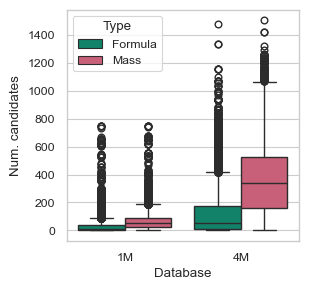

In [18]:
utils.init_plotting(figsize=(3, 3))
sns.boxplot(data=num_cands_df, x='Database', y='Num. candidates', hue='Type')

In [19]:
df_cands_at_k = []
for k in [1, 5, 10, 20]:
    for d in num_cands_df['Database'].unique():
        for t in num_cands_df['Type'].unique():
            df_subset = num_cands_df[(num_cands_df['Database'] == d) & (num_cands_df['Type'] == t)]
            df_cands_at_k.append({
                'Num. candidates < k [%]': (df_subset['Num. candidates'] < k).sum() / len(df_subset) * 100,
                'Database': d,
                'Type': t,
                'k': k
            })
df_cands_at_k = pd.DataFrame(df_cands_at_k)
df_cands_at_k

,Num. candidates < k [%],Database,Type,k
0,8.816391,1M,Formula,1
1,0.049971,1M,Mass,1
2,3.119646,4M,Formula,1
3,0.028555,4M,Mass,1
4,37.428612,1M,Formula,5
5,2.205882,1M,Mass,5
6,14.791548,4M,Formula,5
7,0.399772,4M,Mass,5
8,49.621645,1M,Formula,10
9,6.610508,1M,Mass,10


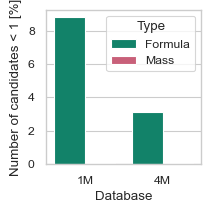

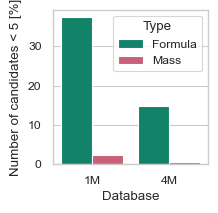

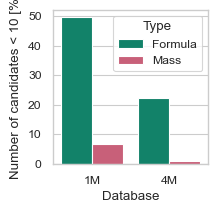

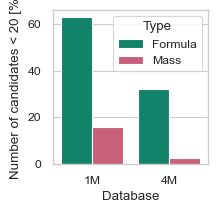

In [20]:
utils.init_plotting(figsize=(2, 2))
for k in df_cands_at_k['k'].unique():
    sns.barplot(data=df_cands_at_k[df_cands_at_k['k'] == k], x='Database', y='Num. candidates < k [%]', hue='Type', hue_order=['Formula', 'Mass'])
    plt.ylabel(f'Number of candidates < {k} [%]')
    plt.show()

100%|██████████| 14008/14008 [05:14<00:00, 44.59it/s] 


<Axes: ylabel='Count'>

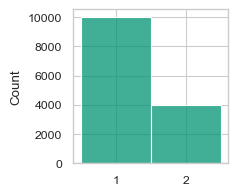

In [21]:
def smiles_to_inchi2d(smiles):
    return Chem.MolToInchiKey(Chem.MolFromSmiles(smiles)).split('-')[0]

num_cands_same_inchi = []
for k, v in tqdm(cands_formula_4M.items()):
    k_inchi = smiles_to_inchi2d(k)
    num_cands_same_inchi.append(sum([smiles_to_inchi2d(s) == k_inchi for s in v]))
num_cands_same_inchi = pd.Series(num_cands_same_inchi)
sns.histplot(num_cands_same_inchi, discrete=True)

In [16]:
# with open('../../data/candidates_formula_1M.json', 'w') as f:
#     json.dump(cands_formula_1M, f)
# with open('../../data/candidates_formula_4M.json', 'w') as f:
#     json.dump(cands_formula_4M, f)
# with open('../../data/candidates_mass_1M.json', 'w') as f:
#     json.dump(cands_mass_1M, f)
# with open('../../data/candidates_mass_4M.json', 'w') as f:
#     json.dump(cands_mass_4M, f)